In [1]:
import os
import time
import logging
import asyncio
import aiohttp
import requests
import nest_asyncio
from functools import reduce
from selenium import webdriver
from fake_headers import Headers

In [2]:
LOG_FORMAT = "%(asctime)s - %(levelname)s - %(message)s"
logging.basicConfig(level=logging.WARNING, format=LOG_FORMAT)
nest_asyncio.apply()

**Use selenium to log in Zhihu.com and get cookies and form data.**

In [4]:
driver = webdriver.Chrome()
driver.get("https://www.zhihu.com/signup?next=%2F")
input('Have been logged in to the website? [Press Enter to continue]')
print('Log in successfully.')

Have been logged in to the website? [Press Enter to continue]
Log in successfully.


In [50]:
def gen_headers():
    headers = {
        'origin': 'https://www.zhihu.com',
        'referer': 'https://www.zhihu.com/topic/19776749/organize/entire',
        'sec-fetch-mode': 'cors',
        'sec-fetch-site': 'same-origin',
        'user-agent': Headers().generate()['User-Agent'],
        'x-requested-with': 'XMLHttpRequest'
    }
    return headers

COOKIES = {c['name']: c['value'] for c in driver.get_cookies()}
FORM = {'_xsrf': COOKIES['_xsrf']}
HEADERS = gen_headers()
SEMA = asyncio.BoundedSemaphore(100)

---

In [53]:
import base64
import numpy as np
from PIL import Image
from io import BytesIO
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
def get_captcha():
    bs64 = requests.get('https://www.zhihu.com/captcha.gif', headers=HEADERS, cookies=COOKIES).content
    image_data = BytesIO(bs64)
    return Image.open(image_data)

**Zhihu has two types of captcha. The latter one is much easier for computer to recognize since each character or number is  always presented in same font and size. We can enumate the captcha if we can get all characters and numbers.**

**So the first step is to distinguish between them.**

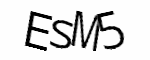

In [84]:
# Type 1
get_captcha()

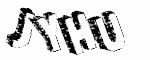

In [85]:
# Type 2
get_captcha()

**It is easy to find that these two types of captcha have significant difference on their grey levels.**

In [51]:
def get_grey_mean(n):
    tasks = [get_grey_mean_co(captcha_url) for i in range(n)]
    loop = asyncio.get_event_loop()
    done, _ = loop.run_until_complete(asyncio.wait(tasks))

grey_mean = []
captcha_url = 'https://www.zhihu.com/captcha.gif'

# Scrap captcha and calculate mean of grayscale
async def get_grey_mean_co(captcha_url):
    async with SEMA:
        async with aiohttp.ClientSession() as s:
            async with s.get(captcha_url, headers=HEADERS, cookies=COOKIES) as resp:
                try:
                    content = await resp.read()
                except UnicodeDecodeError:
                    return
                except ConnectionAbortedError:
                    return
                image_data = BytesIO(content)
                img = Image.open(image_data)
                grey_mean.append((np.array(img)).mean())

get_grey_mean(1000)
grey = np.array(grey_mean)
grey.sort()

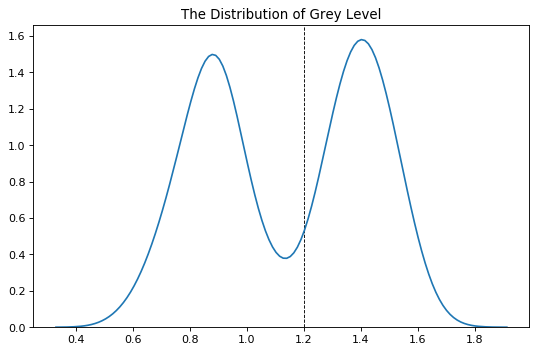

In [86]:
plt.figure(figsize=(8, 5), dpi=80)
plt.axvline(x=1.2, ls='--', c='black', linewidth=0.8)
sns.distplot(grey, hist=False)
plt.title('The Distribution of Grey Level')
plt.show()

---

**Create prototypes for all characters and numbers.**

In [54]:
def cut_h(img, start, end):
    array2D = np.array(img)
    array2D[array2D>0] = 255
    return Image.fromarray((255 - array2D)[:, start:end])

def cut_s(img, k, b, over=True):
    array2D = np.array(img)
    array2D[array2D>0] = 255
    
    h, w = array2D.shape
    array2D = array2D[::-1, :]
    
    for x in range(w):
        for y in range(h):
            if over:
                if k * x - y < - b:
                    array2D[y, x] = 255
            else:
                if k * x - y > - b:
                    array2D[y, x] = 255
                    
    return Image.fromarray(array2D[::-1, :])

def cut_o(img):
    array2D = np.array(img)
    v = np.where(array2D.mean(axis=1) != 255)[0]
    h = np.where(array2D.mean(axis=0) != 255)[0]
    array2D = array2D[v, :][:, h]
    return Image.fromarray(array2D)

def record(key, img):
    img_dict[str(key)] = img
    
img_dict = dict()

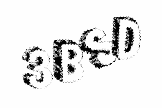

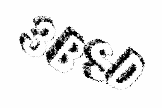

In [90]:
while True:
    bs64 = requests.get('https://www.zhihu.com/captcha.gif', headers=HEADERS, cookies=COOKIES).content
    image_data = BytesIO(bs64)
    img = Image.open(image_data)
    if np.array(img).mean() > 1.2: break
img1 = img.rotate(20, expand=True)
img2 = img.rotate(-20, expand=True)
display.display(img1)
display.display(img2)

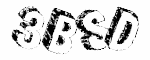

In [91]:
img

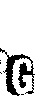

In [63]:
start = 110
end = 150
k = 1
b = 30
direction = 1
img_h = cut_h(img2, start, end)
img_o = cut_o(cut_s(img_h, k, b, direction))
display.display(img_h)
display.display(img_o)

In [ ]:
record('5', img_s)
l = list(img_dict.keys())
l.sort()
print(len(l), l)

---

**Save prototypes**

In [65]:
import pickle

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
save_obj(img_dict, 'img_dict')

---

**Load prototypes**

In [72]:
img_dict = load_obj('img_dict')

In [66]:
from numba import jit
from itertools import product

**It is very likely that characters or numbers in the captcha overlap with each other. A solution is to reduce the influence of those overlapping parts. Notice that most of times these parts locate at the margin of a character, here I Use 2D Gaussian Distribution to increase the weight of center and decrease the weight of margin.**

In [88]:
def gaussian_weight(h, w, sigma=0.8):
    x, y = np.meshgrid(np.linspace(-1,1,w), np.linspace(-1,1,h))
    d = np.sqrt(x*x+y*y)
    mu = 0.0
    g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
    return g

In [80]:
def transform(img):
    array2D = np.array(img)
    array2D[array2D>0] = 255
    return Image.fromarray((255 - array2D))

#def scan(img, img_c):
#    mx1 = 255 - np.array(transform(img), dtype=float)
#    mx2 = 255 - np.array(img_c, dtype=float)
#    h1, w1 = mx1.shape
#    h2, w2 = mx2.shape
#    wt = gaussian_weight(h2, w2)   
#    
#    d_min = np.inf
#    d_w = 0
#    for h in range(h1 - h2):
#        for w in range(w1 - w2):
#            abs_d = np.abs(mx1[h:h+h2, w:w+w2] - mx2)
#            d = (abs_d*wt).mean()
#            if d < d_min:
#                d_min = d
#                d_w = w
#    return d_min, d_w


def mx(img, img_c):
    mx1 = 255 - np.array(transform(img), dtype=float)
    mx2 = 255 - np.array(img_c, dtype=float)
    h2, w2 = mx2.shape
    wt = gaussian_weight(h2, w2)
    return mx1, mx2, wt

@jit(nopython=True)
def scan_jit(mx1, mx2, wt):
    h1, w1 = mx1.shape
    h2, w2 = mx2.shape 
    d_min = np.inf
    d_w = 0
    for h in range(h1 - h2):
        for w in range(w1 - w2):
            abs_d = np.abs(mx1[h:h+h2, w:w+w2] - mx2)
            d = (abs_d*wt).mean()
            if d < d_min:
                d_min = d
                d_w = w
    return d_min, d_w

def scan(img, img_c):
    mx1, mx2, wt = mx(img, img_c)
    d_min, d_w = scan_jit(mx1, mx2, wt)
    return d_min, d_w

def predict(img, img_dict):
    img1 = img.rotate(20, expand=True)
    img2 = img.rotate(-20, expand=True)
    keys = np.array(list(img_dict.keys()))
    a1 = np.array([scan(img1, img_dict[key]) for key in keys])
    a2 = np.array([scan(img2, img_dict[key]) for key in keys])
    r1 = np.argsort(a1[:, 0])
    r2 = np.argsort(a2[:, 0])
    d = np.concatenate([a1[:, 0][r1][:4], a2[:, 0][r2][:4]])
    k = np.concatenate([keys[r1][:4], keys[r2][:4]])
    p = np.concatenate([a1[:, 1][r1][:4], a2[:, 1][r2][:4]])
    prd = k[np.argsort(d)][:4][np.argsort(p[np.argsort(d)][:4])]
    return ''.join(prd)

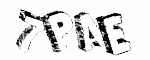

In [78]:
while True:
    bs64 = requests.get('https://www.zhihu.com/captcha.gif', headers=HEADERS, cookies=COOKIES).content
    image_data = BytesIO(bs64)
    img = Image.open(image_data)
    if np.array(img).mean() > 1.2: break
display.display(img)

In [82]:
%%time
predict(img, img_dict)

Wall time: 1.92 s


'7PAE'

---

**DEMO**

In [102]:
from predict_captcha import predict

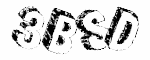

In [104]:
img

In [103]:
%%time
predict(img, img_dict)

Wall time: 2.59 s


'3BSD'